## DSC190 Final Project: NYPD Civilian Complaints


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA

In [40]:
df = pd.read_csv('Data/CCRB-Complaint-Data_202007271729/allegations_202007271729.csv')
df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


In [41]:
#shows where the null values in the table are null. This was helpful when conducting our missingness test.
null_props = pd.isnull(df).mean()
null_props

unique_mos_id               0.000000
first_name                  0.000000
last_name                   0.000000
command_now                 0.000000
shield_no                   0.000000
complaint_id                0.000000
month_received              0.000000
year_received               0.000000
month_closed                0.000000
year_closed                 0.000000
command_at_incident         0.046286
rank_abbrev_incident        0.000000
rank_abbrev_now             0.000000
rank_now                    0.000000
rank_incident               0.000000
mos_ethnicity               0.000000
mos_gender                  0.000000
mos_age_incident            0.000000
complainant_ethnicity       0.133821
complainant_gender          0.125757
complainant_age_incident    0.144253
fado_type                   0.000000
allegation                  0.000030
precinct                    0.000719
contact_reason              0.005966
outcome_description         0.001679
board_disposition           0.000000
d

In [42]:
#we looked at the data types of every column
df.dtypes

unique_mos_id                 int64
first_name                   object
last_name                    object
command_now                  object
shield_no                     int64
complaint_id                  int64
month_received                int64
year_received                 int64
month_closed                  int64
year_closed                   int64
command_at_incident          object
rank_abbrev_incident         object
rank_abbrev_now              object
rank_now                     object
rank_incident                object
mos_ethnicity                object
mos_gender                   object
mos_age_incident              int64
complainant_ethnicity        object
complainant_gender           object
complainant_age_incident    float64
fado_type                    object
allegation                   object
precinct                    float64
contact_reason               object
outcome_description          object
board_disposition            object
dtype: object

We first examined the ages of complainants and we found that some were negative or very low values. In addition, -1 was probably used as a placeholder for nan so this was something we needed to change. We chose to convert all ages 7 and under to nan because based on the data generating process these values were unlikely. We also looked at those who may be too old to file a complaint, however the oldest age was 101 which seemed possible. Moreover, there were only a few rows with these values so converting them to nan would not bias the result much.

In [43]:
weird_ages = df['complainant_age_incident'].value_counts().sort_index().head(10)
weird_ages

-4301.0    1
-1.0       5
 0.0       2
 1.0       1
 2.0       2
 3.0       1
 6.0       1
 7.0       1
 8.0       3
 9.0       4
Name: complainant_age_incident, dtype: int64

In [44]:
replacable_indexes = df['complainant_age_incident'].value_counts().sort_index().head(20).index[:8] #here we sorted the values to find those that seemed too young to file a complaint
my_dict = {i:np.NaN for i in replacable_indexes} #replaced all unusual ages with nans
fixed_ages = df.assign(complainant_age_incident = df['complainant_age_incident'].replace(my_dict)) #modified the original dataframe to reflect the nans

We continued to clean the dataframe by looking where the ethnicity were Unknown and where individuals refused to state their race. We then changed those values to nans. We also checked where complainant gender was not described and changed those to nan in our dataframe.

In [45]:
fixed_race_and_age = fixed_ages.assign(complainant_ethnicity = fixed_ages['complainant_ethnicity'].replace({'Unknown':np.NaN, 'Refused':np.NaN}))#replaced unknown and refused with nan in ethnicity
fixed_df = fixed_race_and_age.assign(complainant_gender = fixed_race_and_age['complainant_gender'].replace({'Not described' : np.NaN})) #replaced not described with nan in gender
fixed_df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,mos_age_incident,complainant_ethnicity,complainant_gender,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,32,Black,Female,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions)
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,24,Black,Male,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges)
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,25,Black,Male,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges)
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,39,NaN,NaN,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A)


We found the month and year a complaint is received as well as the month and year the complaint is closed. We then converted these values to datetime so we could subtract the values. This would give us the number of days that it to close the case. We considered this to be the wait time. Since we don't have the exact date the complaint was filed, we assumed the first of the month for both received and closed dates. Since our analysis mainly focuses on relative wait times this should not impact the results too much.

In [46]:
received_date = fixed_df['month_received'].astype(str) + "/" + fixed_df['year_received'].astype(str) #combined month and year to find date received
closed_date = fixed_df['month_closed'].astype(str) + "/" + fixed_df['year_closed'].astype(str) #combined month and year to find date closed
fixed_df['received_date'] = pd.to_datetime(received_date) #changed received date to datetime
fixed_df['closed_date'] = pd.to_datetime(closed_date)#changed closed date to datetime
fixed_df['wait_time'] = (fixed_df['closed_date'] - fixed_df['received_date']).dt.days #subtracted days to find the days took to resolve complaint
fixed_df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,received_date,closed_date,wait_time
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated (Command Lvl Instructions),2019-07-01,2020-05-01,305
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated (Charges),2011-11-01,2012-08-01,274
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated (Charges),2012-07-01,2013-09-01,427
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated (Command Discipline A),2018-08-01,2019-02-01,184


The board disposition gave an account of what happened to the accused Police Officer ie. Substantiated implies that the complaint was valid, and disciplinary action was taken against the PO. Unsubstantiated implies that they could not come to a conclusion, whereas exonerated means the officer was innocent and the complaint is dismissed. Within Substantiated there were multiple divisions describing the action taken against the officer. For our analysis we decided to just group all of these divisions into one category that we called substantiated.

In [47]:
altered_series = fixed_df['board_disposition'].replace({i: 'Substantiated' for i in fixed_df['board_disposition'] if 'Substantiated' in i}) #we grouped all the substantiated categories into just substantiated
fixed_df = fixed_df.assign(board_disposition=altered_series) #we assigned those values that become substantiated into the dataframe
fixed_df.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,received_date,closed_date,wait_time
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated,2019-07-01,2020-05-01,305
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated,2011-11-01,2012-08-01,274
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated,2011-11-01,2012-08-01,274
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated,2012-07-01,2013-09-01,427
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated,2018-08-01,2019-02-01,184


##### Note: 
fixed_df is our final cleaned dataframe. We looked at each of the other columns for any anomaly/outlier values or anything else that needed to be replaced with NaN. We found that everything else looked alright and with that finished our cleaning and moved on to EDA.

# Univariate Analysis

#### Question:
What is the distribution of ethnicities? Which ethnicity has filed the most number of complaints?

The cell below outputs the proportion of complaints filed by each ethnicity. 

,complainant_ethnicity
Black,0.620207
Hispanic,0.232804
White,0.100855
Other Race,0.024534
Asian,0.019280
American Indian,0.002319


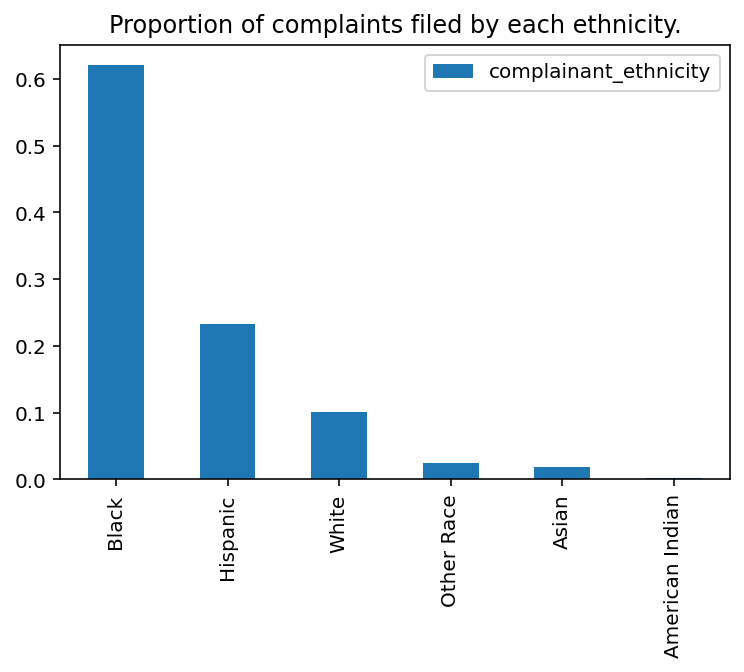

In [66]:
ethnicity_counts = fixed_df['complainant_ethnicity'].value_counts(normalize = True).to_frame()
ethnicity_counts.plot(kind = 'bar', title = 'Proportion of complaints filed by each ethnicity.');
display(ethnicity_counts)


#### Result
From this graph we can see that most of the complaints were submitted by people of color.

#### Question:
What is the distribution of ethnicities for officers? Which ethnicity do most officers belong to within this dataset?

The cell below outputs the proportion of officers from each ethnicity who have a complaint filed against them.

,mos_ethnicity
White,0.541819
Hispanic,0.274297
Black,0.147611
Asian,0.035314
American Indian,0.000959


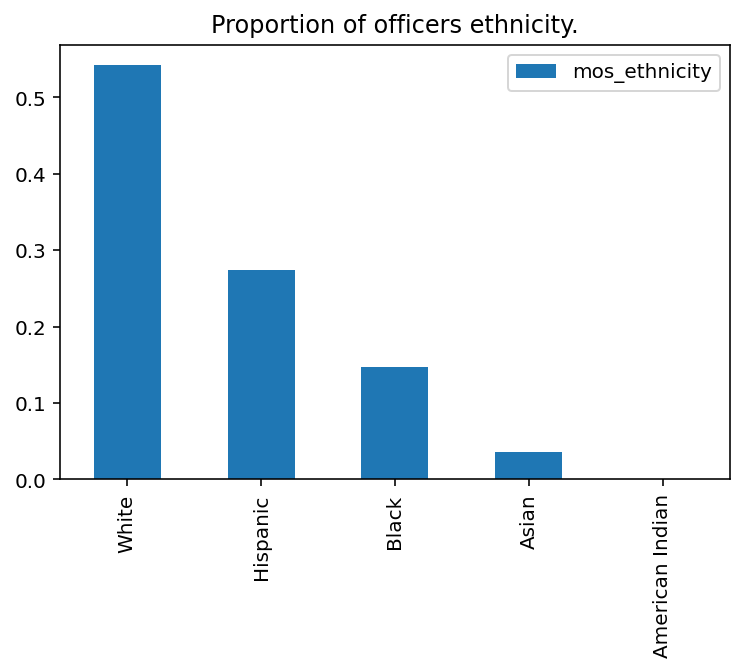

In [116]:
ethnicity_counts_officers = fixed_df['mos_ethnicity'].value_counts(normalize = True).to_frame()
display(ethnicity_counts_officers)
ethnicity_counts_officers.plot(kind = 'bar', title = 'Proportion of officers ethnicity.');

#### Result:
From this graph we can see that most of the complaints are filed against white officers. This is probably due to the fact that there are more white officers than those of color in this dataset.

# Bivariate Analysis, Aggregates And Pivot Tables

#### Question:
Is there any association between age and wait time?

The cell below creates a scatter plot examining the association between age and wait time.

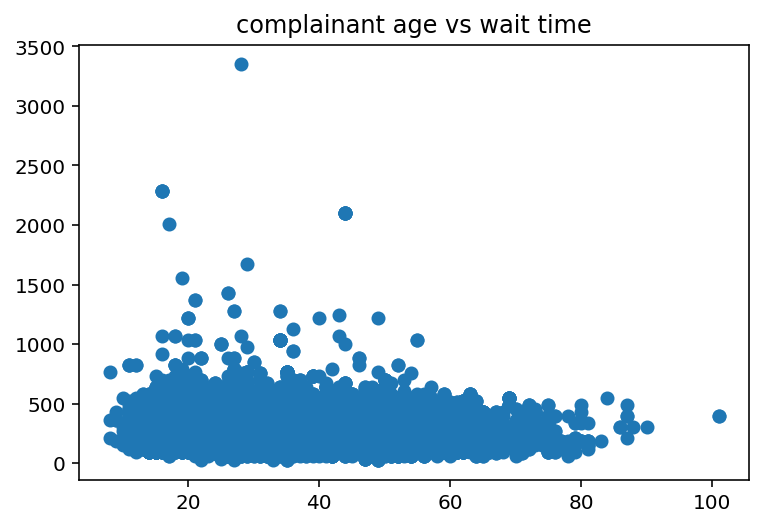

In [14]:
plt.scatter(fixed_df['complainant_age_incident'], fixed_df['wait_time']); #plotted age vs wait time, there does not appear to be any correlation
plt.title('complainant age vs wait time');


#### Result
There doesn’t seem to be any correlation between age and wait time in this data set. However it appears that as age increases the variance in the wait times decreases, but this is probably because of the fewer number of people in the older age groups.

# Aggregates and Pivot Tables

#### Question:
Does the severity of the accusation depend on the ethnicity of the complainant?

The cell below outputs a plot that shows the proportion of complaints for each fado type across ethnicities. 

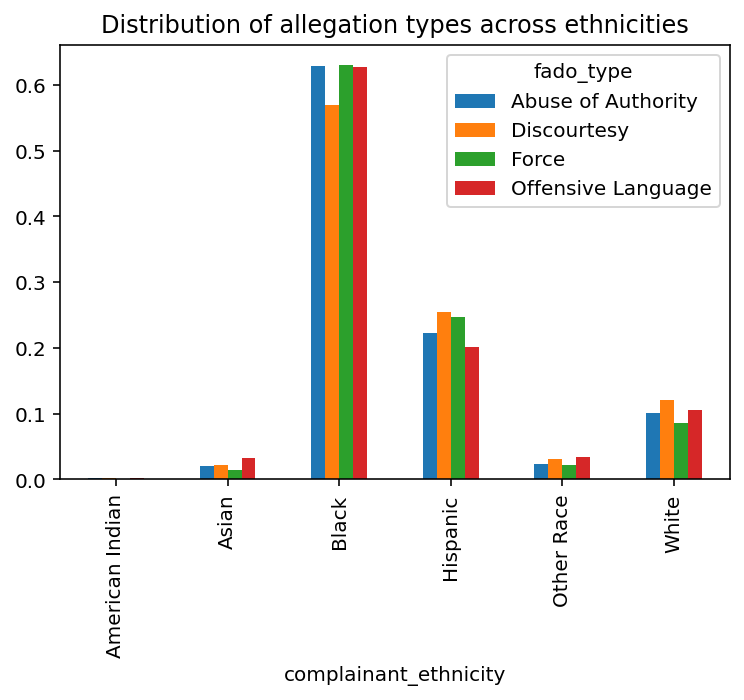

In [18]:
mod_pivot = fixed_df.pivot_table(index = 'complainant_ethnicity', columns ='fado_type', aggfunc ='size') #found the number of complaints for each ethnicity for each fado type using a pivot table
(mod_pivot / mod_pivot.sum()).plot(kind = 'bar', title = 'Distribution of allegation types across ethnicities'); #converted counts to proportion


#### Result:
From this graph we can see which fado type is more common based on ethnicity. In most ethnicities besides the black community, discourtesy seems to be the most common. However among those of color force and abuse of authority seem to be more common. This shows that the allegation is more severe for those of color.

#### Question:
Which gender has the highest average wait time?

Outputs a bar graph representing the average wait times across genders

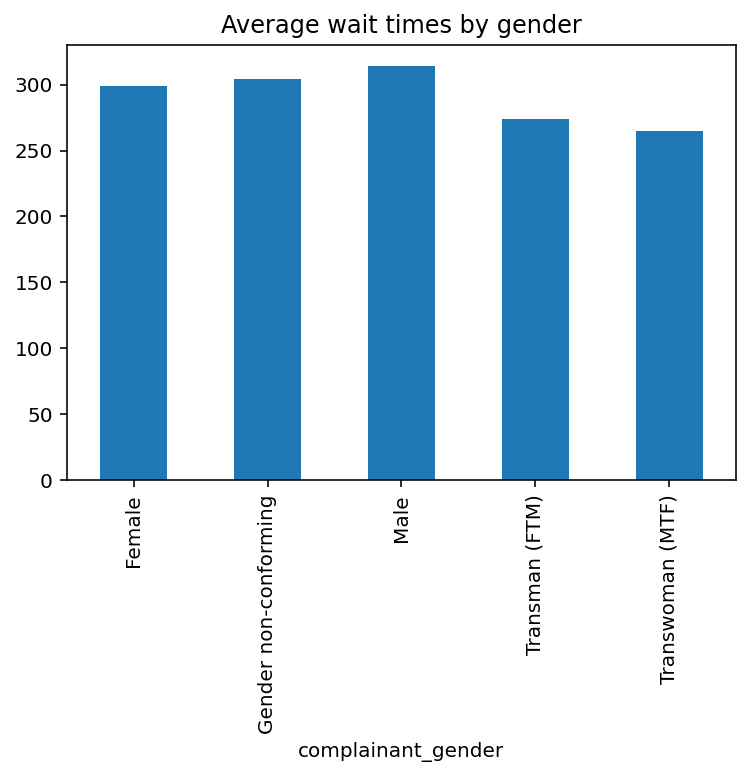

In [19]:
my_analysis = fixed_df[['complainant_gender', 'complainant_age_incident', 'complainant_ethnicity', 'wait_time']]
my_analysis.groupby('complainant_gender')['wait_time'].mean().plot(kind = 'bar', title = 'Average wait times by gender'); # male vs. female average wait times

#### Result
The average wait time for males is slightly higher compared to those of other genders. Since the differences are really small, the result could just be due to randomness and would need a more detailed test to confirm.

#### Question
What are the average wait times by complainant ethnicity?

Outputs the average wait times across ethnicities

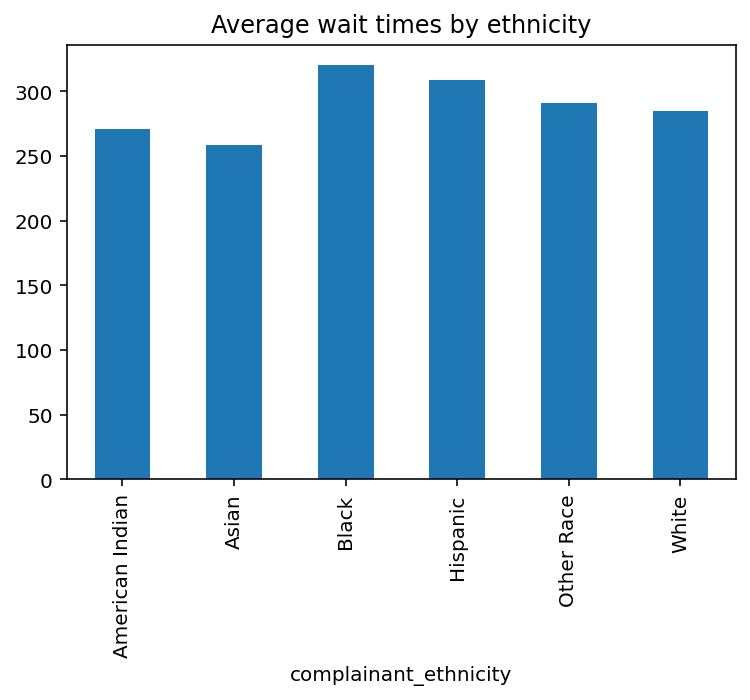

In [20]:
my_analysis.groupby('complainant_ethnicity')['wait_time'].mean().plot(kind = 'bar', title = 'Average wait times by ethnicity'); 

In [50]:
fixed_df['fado_type'].unique()

array(['Abuse of Authority', 'Discourtesy', 'Offensive Language', 'Force'],
      dtype=object)

#### Result
The average wait time by ethnicity shows that those of people of color have higher wait times than other ethnicities.

#### Question:
Does the outcome of the case have anything to do with the complainant's ethnicity? For example, are complaints filed by people of color more likely to end up in the officer being exonerated?

Outputs a plot describing the proportion of complaints in each type of board_disposition across ethnicities.

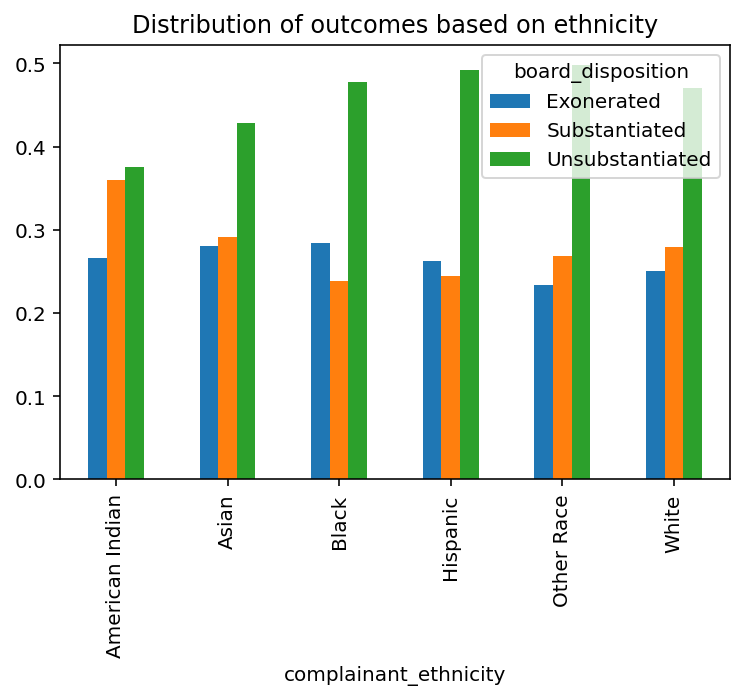

In [21]:
altered_df = fixed_df[['complainant_ethnicity', 'board_disposition']]
pivot_1 = altered_df.pivot_table(index='complainant_ethnicity', columns = 'board_disposition', aggfunc = 'size')# Created a pivot table that shows the number of complaints per ethnicity for each outcome 
pivot_1.apply(lambda x: x/x.sum(), axis = 1).plot(kind = 'bar', title = 'Distribution of outcomes based on ethnicity'); # converted counts to proportions



#### Result:
We found that for all races except Blacks and Hispanics the proportion of substantiated cases was higher than exonerated cases. This could imply a racial bias against complainants from the black and hispanic communities.

#### Question
Are white-officer vs non-white complainant cases more likely to go against the complainant?

First we found where the complainant was not white and where the police officer was white. We put these bool values in the dataframe with a column called ethnicity_status. We ensured that the places that originally had NaN values in complainant ethnicities continued to be NaN in the new column.

In [22]:
bool_series = ((fixed_df['complainant_ethnicity'] != 'White') & (fixed_df['mos_ethnicity'] == 'White')).replace({True:1, False:0})
perm_df = fixed_df[['board_disposition']]
perm_df = perm_df.assign(ethnicity_status = bool_series)
indexes = fixed_df.loc[pd.isnull(fixed_df['complainant_ethnicity'])].index # finds indexes where ethnicity is NaN in the orginial dataframe.
perm_df['ethnicity_status'].loc[indexes] = np.NaN # Makes the corresponding values in ethnicity_status NaN.
perm_df.head()

/Users/moksha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,board_disposition,ethnicity_status
0,Substantiated,0.0
1,Substantiated,1.0
2,Substantiated,1.0
3,Substantiated,1.0
4,Substantiated,NaN


We then plotted a bar graph which shows the proportion of different complaint outcomes when the officer is white and the complainant is non-white (1.0) vs. all other possibilities.

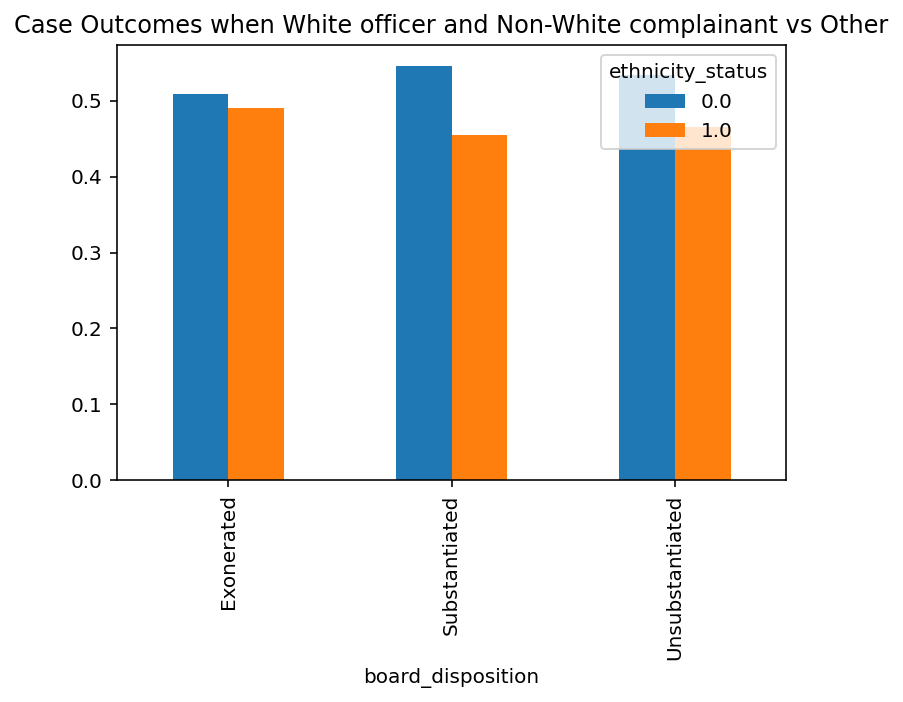

In [36]:
perm_pivot = perm_df.pivot_table(index = 'board_disposition', columns = 'ethnicity_status', aggfunc = 'size')
perm_props = perm_pivot.apply(lambda x: x/x.sum(), axis = 1)
perm_props.plot(kind = 'bar', title = 'Case Outcomes when White officer and Non-White complainant vs Other');

#### Result:
We found the difference between substantiated case proportions and exonerated case proportions based on the officer and complainant’s ethnicity. When the complainant was not white and where the police officer was white vs all other outcomes the difference in proportions was greater for substantiated cases. This might indicate that complaints are more likely to go against the complainant when the officer is white and the complainant is non white.

#### Question:
Is the outcome of the complaint related to the rank of the officer? eg. are higher ranking officers more likely to be exonerated?

Cell creates a pivot table with the number of complaint outcomes for each rank and each outcome.

In [24]:
new_pivot = fixed_df.pivot_table(index = 'rank_incident', columns = 'board_disposition', aggfunc = 'size') #number of each outcome based on rank of the officer
new_pivot

board_disposition,Exonerated,Substantiated,Unsubstantiated
rank_incident,,,
Captain,91.0,37.0,54.0
Chiefs and other ranks,1.0,NaN,1.0
Deputy Inspector,25.0,25.0,46.0
Detective,858.0,687.0,1762.0
Inspector,8.0,5.0,14.0
Lieutenant,444.0,248.0,609.0
Police Officer,6335.0,5945.0,10229.0
Sergeant,1847.0,1354.0,2733.0


This cell diplays the above pivot table in the form of proportions.

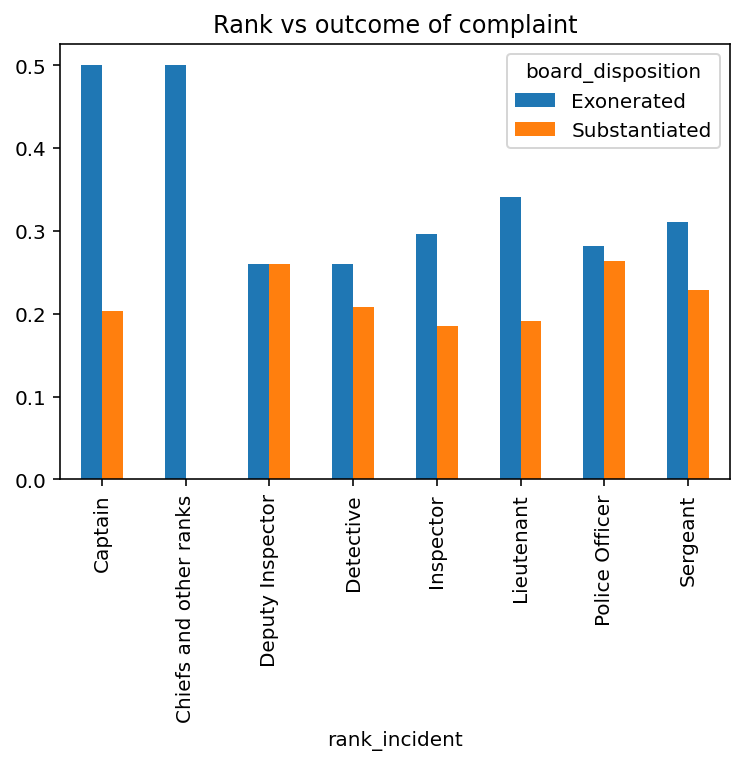

In [25]:
my_mod = new_pivot.apply(lambda x: x/x.sum(), axis = 1)[['Exonerated', 'Substantiated']] #removed unsubtantiated because across ranks the number of unsubtantiated were significantly higher
my_mod.plot(kind = 'bar', title = 'Rank vs outcome of complaint');

In order to make the difference in the number of substantiated vs exonerated cases more clear, we plotted the differences for each rank in a bar graph.

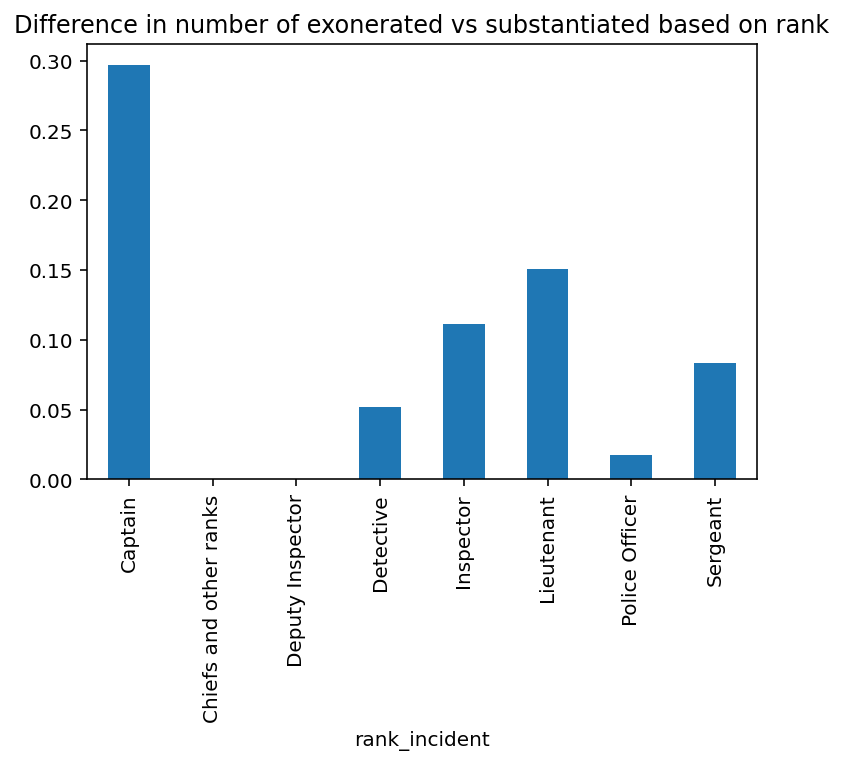

In [26]:
(my_mod['Exonerated'] - my_mod['Substantiated']).plot(kind = 'bar', title = 'Difference in number of exonerated vs substantiated based on rank');

#### Result:
Rank order from online source: police officer, sergeant, lieutenant, captain, inspector, and then chiefs. According to this, for the most part, the higher the rank the more difference in outcomes. This means that there is a higher rate of being exonerated among higher ranks.

### Assessment of Missingness

We conducted a missingness test on complainant ethnicity to see which columns were MAR. We used the Total Variation Distance as our test stat since we are working with two categorical columns. Since our significant level was 0.05 any p-value below that would suggest that ethnicity was MAR with respect to the other column. We chose to check the missingness of complainant ethnicity to help answer our question: are white officers vs non white complainant cases more likely to go against the complainant? We address this question in our next section using a permutation test.

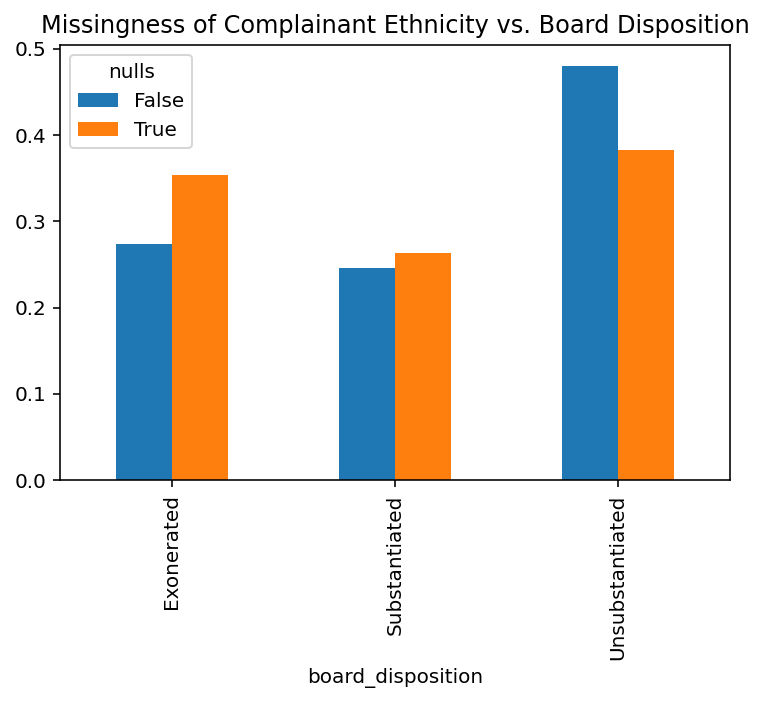

In [54]:
missing_test = fixed_df[['complainant_ethnicity',  'board_disposition']]
missing_test = missing_test.assign(nulls = pd.isnull(missing_test['complainant_ethnicity'])) # created a column (nulls) of booleans indicating where complainant_ethnicity is null and assigned to a df.
mod_pivot = missing_test.pivot_table(index = 'board_disposition', columns = 'nulls', aggfunc = 'size').apply(lambda x: x/x.sum())
mod_pivot.plot(kind = 'bar', title = 'Missingness of Complainant Ethnicity vs. Board Disposition');

We plotted the distribution of board dispositions when the complainant ethnicity column is null and not null. We found that the distributions looked fairly different and thus proceeded with the missingness test. 
(We could not do the same for complaint_id because there are too many unique ids to give a clear visualization)

In [27]:
def ethnicity_missingness(col2):
    missing_test = fixed_df[['complainant_ethnicity',  col2]]
    missing_test = missing_test.assign(nulls = pd.isnull(missing_test['complainant_ethnicity'])) # created a column (nulls) of booleans indicating where complainant_ethnicity is null and assigned to a df.
    mod_pivot = missing_test.pivot_table(index = 'nulls', columns = col2, aggfunc = 'size').apply(lambda x: x/x.sum(), axis=1) # created a pivot table which shows the distribution of col2 when the nulls column is true vs. when it is false.
    obs_tvd = mod_pivot.diff().iloc[-1].abs().sum()/2 # Observed statistic.
    tvds = []
    for i in range(1000):
        shuffled = missing_test['nulls'].sample(frac=1, replace=False).reset_index(drop=True) # shuffling the column of booleans.
        missing = missing_test.assign(nulls = shuffled)
        mod_pivot = missing.pivot_table(index = 'nulls', columns = col2, aggfunc = 'size').apply(lambda x: x/x.sum(), axis=1)
        tvd = mod_pivot.diff().iloc[-1].abs().sum()/2 # calculate the sample statistic.
        tvds.append(tvd)
    return(tvds >= obs_tvd).mean()

In [30]:
ethnicity_missingness('complaint_id')

1.0

In [31]:
ethnicity_missingness('board_disposition')

0.0

#### Results:
Since the p-value when we compared complainant_ethnicity to complaint_id was 1, we would fail to reject the null hypothesis which means that complainant_ethnicity is likely not MAR with respect to complaint_id. On the other hand, when we compared ethnicity to board_disposition we found a pvalue of 0, indicating with high probability that complainant_ethnicity is MAR on board_dispostion. This could lead to a potential bias in our permutation test results.

### Permutation Test

### Question: Are white-officer vs non-white complainant cases more likely to go against the complainant?

### a) Permutation Test
We first begin with a permutation test that checks if the distribution of complaint outcomes are significantly different when the officer is white and the complaintant is not white vs. when this is not the case using board dispositon

We first check which rows satisfy the condition of having white officers with non-white complainants. If they are of different races we set the value to be 1, and if they don't meet that requirement we set it to zero and saved in an array. We then added to a dataframe containg the board_disposition column. We used board_dispositon as an indicator of whether the case was ruled in favor of or against the complainant. Exonerated implied it went against the complainant. Unsubstantiated implies there was no conclusion and Substantiated implied action was taken and the case ruled in favor of the complainant

In [70]:
# If ethnicity was the same, replaced True with 1, False with 0, added to dataframe.
bool_series = ((fixed_df['complainant_ethnicity'] != 'White') & (fixed_df['mos_ethnicity'] == 'White')).replace({True:1, False:0})
perm_df = fixed_df[['board_disposition']]
perm_df = perm_df.assign(ethnicity_status = bool_series)
perm_df.head()

,board_disposition,ethnicity_status
0,Substantiated,0
1,Substantiated,1
2,Substantiated,1
3,Substantiated,1
4,Substantiated,0


Initially, if ethnicity was NaN, ethnicity_status took the value 0 automatically. This would bias the results. That's why we wanted to keep the original NaN values in the new ethnicity_status column.

In [71]:
indexes = fixed_df.loc[pd.isnull(fixed_df['complainant_ethnicity'])].index # finds indexes where ethnicity is NaN in the orginial dataframe.
perm_df['ethnicity_status'].loc[indexes] = np.NaN # Makes the corresponding values in ethnicity_status NaN.
perm_df.head()

/Users/moksha/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,board_disposition,ethnicity_status
0,Substantiated,0.0
1,Substantiated,1.0
2,Substantiated,1.0
3,Substantiated,1.0
4,Substantiated,NaN



Null Hypothesis: White officer with non-white complainant vs those that don't meet that requirement come from the same underlying distribution.

Alternative Hypothesis: White officer with non-white complainant vs those that don't meet that requirement come from two different distributions.

The test statistic we choose is the total variation distance (TVD) between the distributions when the officer is white and the complainant is non-white vs. those that don't meet that requirement. We chose this statistic because it works best when we have two categorical distributions.

The significance level we chose is .05.

With this permutation test, we aim to check if when a white officer is being accused by a non-white complainant, the distribution of case outcomes is significantly different than those that don't meet that requirement.


We first created a pivot table to show the number of cases under each possible board disposition for both cases. We then converted them into proportions and used it to calculate the observed statistic.

In [72]:
my_pivot = perm_df.pivot_table(index = 'board_disposition', columns = 'ethnicity_status', aggfunc='size') # creates a pivot table where each cell represents the number of cases under each possible board disposition for both the 0 and 1 case.
distr = my_pivot / my_pivot.sum() # converts to proportions
distr

ethnicity_status,0.0,1.0
board_disposition,,
Exonerated,0.263399,0.286596
Substantiated,0.253008,0.237621
Unsubstantiated,0.483593,0.475783


In [73]:
obs_tvd = distr.diff(axis=1).loc[:, 1].abs().sum() / 2
obs_tvd # observed test statistic

0.02319675096488233

This cell block performs the permutation test and subsequently calculates the p-value.

In [74]:
# Permutation test with N = 1000 trials.
tvds = []
for i in range(1000):
    shuffled = perm_df['board_disposition'].sample(frac = 1 , replace = False).reset_index(drop=True) # shuffles the board_disposition column.
    new_df = perm_df[['ethnicity_status']].assign(shuffled = shuffled) # assigns shuffled to a new dataframe
    my_pivot = new_df.pivot_table(index = 'shuffled' , columns = 'ethnicity_status', aggfunc='size')
    props = my_pivot / my_pivot.sum()
    tvd = props.diff(axis=1).loc[:, 1].abs().sum() / 2 # calculate observed statistic
    tvds.append(tvd)

In [75]:
p_val = (tvds >= obs_tvd).mean() # calculates p_val
p_val

0.0

Here we plot the distribution of sample tvds in a histogram along with the observed statistic.

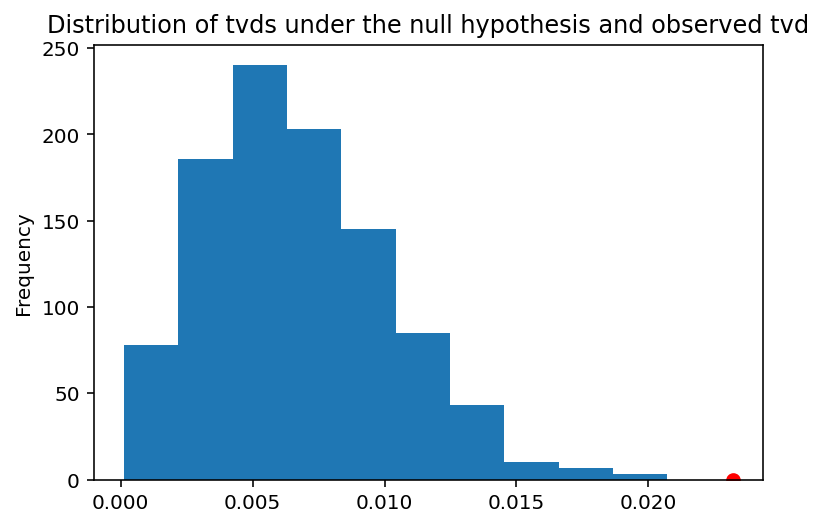

In [76]:
pd.Series(tvds).plot(kind='hist', title = 'Distribution of tvds under the null hypothesis and observed tvd')
plt.scatter(obs_tvd, 0.01, color='red', s= 40, zorder = 2);

### Result
We got a p-value of 0.0 which indicates that with very high probability, the distribution of outcomes for white officers with non white complainants vs those that don't meet that requirement is significantly different. 

### Shortcomings
While the permutation test was effective in establishing an association between complainant and mos_ethnicity and the outcome of the case, it does not answer the more specific question of whether white officers are more likely to be exonerated or substantiated when accused by non white complainants because it is not a directional test.

In addition, the ethnicitiy_status column is MAR on board_disposition. (Because complainant_ethnicity is MAR on board_dispostion and ethnicity_status is NaN whenever complainant_ethnicity is NaN). Since we have not imputed the NaN values, this may lead to some bias in our analysis.

### Conclusion:
With the given dataset we were able to analyze interesting trends in the data and identify an association between the ethnicities of the complainants and police officers and the outcome of the complaint. 
One way in which our results could be improved is by imputing our null values using the appropriate technique (conditional imputation for MAR columns). 
We would also potentially like to explore the proportion of complaints for each fado type across ethnicities for the same contact reason. For example, for the same contact reason, what proportion of black complainants accused the officer of using force vs. the proportion of white people who do the same. Currently, because the proportion of complaints from people who are from the Black community is much higher than any other ethnicity, this type of analysis is not possible. So over time, getting more data to get a more balanced dataset would be helpful.

### Predictive Model

In [4]:
df = pd.read_csv("data/allegations_202007271729.csv")

In [5]:
df['board_disposition'].unique()
mod_df = df.dropna() # Dropped NaN values
target = (mod_df['board_disposition'] == 'Exonerated').astype(np.int64)

We chose the following features for our models because we felt they were most relevent to our prediction task.

In [75]:
features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type', 'mos_age_incident', 'complainant_age_incident', 'year_received', 'year_closed']


Created a baseline model using sklearn pipelines. We first one hot encoded all our categorical variables and then used a DecisionTreeClassifer to make our predictions.

In [76]:
cat_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type']
pl1 = Pipeline([('one-hot', OneHotEncoder(handle_unknown = 'ignore'))])
preproc = ColumnTransformer(transformers = [('cat-cols', pl1, cat_features)], remainder = 'passthrough')
pl = Pipeline([('pre-proc', preproc), ('decision-tree', DecisionTreeClassifier())])

Split the data into training and testing set. We fit our model on the training set.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(mod_df[features], target, test_size = 0.3, random_state = 12)

In [78]:
pl.fit(X_train, y_train)

Pipeline(steps=[('pre-proc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat-cols',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity',
                                                   'complainant_gender',
                                                   'fado_type'])])),
                ('decision-tree', DecisionTreeClassifier())])

We performed a k-fold cross validation and found the mean accuracy across the folds.

In [79]:
cross_val_score(pl, X_train, y_train, cv=5).mean()

0.7108326209595139

We then found our model's accuracy on the testing data.

In [80]:
pl.score(X_test, y_test)

0.7106139933365064

In [81]:
baseline_predictions = pl.predict(X_test)

We then created a confusion matrix to check for other meaures of accuracy.

In [82]:
metrics.confusion_matrix(y_test, baseline_predictions)


array([[4981, 1120],
       [1312,  991]])

In [83]:
metrics.recall_score(y_test, baseline_predictions)

0.430308293530178

In [84]:
metrics.recall_score(y_test, baseline_predictions, pos_label = 0) # Specificity

0.8164235371250614

We then began creating our pipeline for our final model. We one hot encoded our categorical variables, created a new transformer to enginner a wait time features and then standardized all the quantitaive features.

In [116]:
def wait_times(x):
    return (x['year_closed'] - x['year_received']).to_frame()

We began our model selection process by creating separate pipelines for each posssible classification model.

In [118]:
pl_final = Pipeline([('pre-proc', preproc), ('decision-tree', DecisionTreeClassifier())])
pl_final_1 = Pipeline([('pre-proc', preproc), ('random-forest', RandomForestClassifier())])
pl_final_2 = Pipeline([('pre-proc', preproc), ('k-neighbor', KNeighborsClassifier())])
pl_final_3 = Pipeline([('pre-proc', preproc), ('regression', LogisticRegression())])

We performed cross-validation for each model and found the one with the highest mean accuracy.

In [87]:
list_fin = [pl_final, pl_final_1, pl_final_2, pl_final_3]
empty_list = []
for i in list_fin:
    empty_list.append(cross_val_score(i, X_train, y_train, cv=5))

/Users/moksha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/moksha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [88]:
[i.mean() for i in empty_list]

[0.6972153499228322,
 0.7111379890522678,
 0.7084351693004665,
 0.7339862592161533]

We wanted to optimize the parameters for our chosen RandomForestModel. We used GridSearchCV to do so.

In [89]:
pl_final_1.fit(X_train, y_train)

Pipeline(steps=[('pre-proc',
                 ColumnTransformer(transformers=[('cat-cols',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity',
                                                   'complainant_gender',
                                                   'fado_type']),
                                                 ('time-elapsed',
                                                  Pipeline(steps=[('transform',
                                                                   FunctionTransformer(func=<function <lambda> at 0x12a609f70>)),
                                                                  ('scaler',
                    

In [90]:
X_train_new = preproc.transform(X_train)

In [26]:
parameters = {
    'max_depth': [2,4,7,13,18,None], 
    'min_samples_split':[2,5,10,15],
    'min_samples_leaf':[2,5,10,20],
    'n_estimators' : [200, 600, 1000, 1400, 1800]
}
grid_search = GridSearchCV(RandomForestClassifier(), parameters, cv = 3)
grid_search.fit(X_train_new, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 7, 13, 18, None],
                         'min_samples_leaf': [2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [200, 600, 1000, 1400, 1800]})

In [27]:
grid_search.best_params_

{'max_depth': 18,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

Here we create our final model using the optimized parameters.

In [148]:
pl1 = Pipeline([('one-hot', OneHotEncoder(handle_unknown = 'ignore'))])
#pl2 = Pipeline([('transform', FunctionTransformer(wait_times)), ('scaler', StandardScaler())])
pl3 = Pipeline([('scaler', StandardScaler())])
cat_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender', 'fado_type']
preproc = ColumnTransformer(transformers = [('cat-cols', pl1, cat_features),('scaled', pl3, ['mos_age_incident', 'complainant_age_incident', 'wait_time'])])



In [149]:
pl_optimized = Pipeline([('pre-proc', preproc), ('random-forest', RandomForestClassifier(max_depth = 18,min_samples_leaf= 2, min_samples_split= 2,n_estimators= 200))])


In [151]:
X_train['wait_time'] = X_train['year_closed'] - X_train['year_received']

In [152]:
X_train= X_train.drop(['year_closed', 'year_received'], axis = 1)

In [153]:
pl_optimized.fit(X_train, y_train)

Pipeline(steps=[('pre-proc',
                 ColumnTransformer(transformers=[('cat-cols',
                                                  Pipeline(steps=[('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['mos_ethnicity',
                                                   'mos_gender',
                                                   'complainant_ethnicity',
                                                   'complainant_gender',
                                                   'fado_type']),
                                                 ('scaled',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['mos_age_incident',
                                                   'complainant_age_incident'

In [141]:
X_train['fado_type'].unique()

array(['Abuse of Authority', 'Force', 'Discourtesy', 'Offensive Language'],
      dtype=object)

In [147]:
pl_optimized.predict(pd.DataFrame({'mos_ethnicity':'Hispanic', 'mos_gender': 'M', 'complainant_ethnicity':'Black', 'complainant_gender':'Male','fado_type':'Force', 'mos_age_incident':26, 'complainant_age_incident':22.0, 'year_received':2005, 'year_closed':2007}, index = [0]))
                     
                     
                     

array([1])

In [154]:
pickle.dump(pl_optimized, open('model.pkl', 'wb'))

In [130]:
fixed_df.head(50)

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,complainant_age_incident,fado_type,allegation,precinct,contact_reason,outcome_description,board_disposition,received_date,closed_date,wait_time
0,10004,Jonathan,Ruiz,078 PCT,8409,42835,7,2019,5,2020,...,38.0,Abuse of Authority,Failure to provide RTKA card,78.0,Report-domestic dispute,No arrest made or summons issued,Substantiated,2019-07-01,2020-05-01,305
1,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,26.0,Discourtesy,Action,67.0,Moving violation,Moving violation summons issued,Substantiated,2011-11-01,2012-08-01,274
2,10007,John,Sears,078 PCT,5952,24601,11,2011,8,2012,...,26.0,Offensive Language,Race,67.0,Moving violation,Moving violation summons issued,Substantiated,2011-11-01,2012-08-01,274
3,10007,John,Sears,078 PCT,5952,26146,7,2012,9,2013,...,45.0,Abuse of Authority,Question,67.0,PD suspected C/V of violation/crime - street,No arrest made or summons issued,Substantiated,2012-07-01,2013-09-01,427
4,10009,Noemi,Sierra,078 PCT,24058,40253,8,2018,2,2019,...,16.0,Force,Physical force,67.0,Report-dispute,Arrest - other violation/crime,Substantiated,2018-08-01,2019-02-01,184
5,10012,Paula,Smith,078 PCT,4021,37256,5,2017,10,2017,...,31.0,Abuse of Authority,Refusal to process civilian complaint,78.0,C/V telephoned PCT,No arrest made or summons issued,Substantiated,2017-05-01,2017-10-01,153
6,10014,Malachy,Sullivan,078 PCT,4143,33969,11,2015,2,2016,...,34.0,Offensive Language,Sexual orientation,78.0,PD suspected C/V of violation/crime - street,Summons - other violation/crime,Substantiated,2015-11-01,2016-02-01,92
7,10017,Fazle,Tanim,078 PCT,15187,40070,8,2018,11,2018,...,60.0,Discourtesy,Word,78.0,Moving violation,Moving violation summons issued,Unsubstantiated,2018-08-01,2018-11-01,92
8,10017,Fazle,Tanim,078 PCT,15187,41927,3,2019,8,2019,...,39.0,Abuse of Authority,Refusal to provide shield number,78.0,Moving violation,Moving violation summons issued,Unsubstantiated,2019-03-01,2019-08-01,153
9,10017,Fazle,Tanim,078 PCT,15187,41927,3,2019,8,2019,...,39.0,Abuse of Authority,Retaliatory summons,78.0,Moving violation,Moving violation summons issued,Substantiated,2019-03-01,2019-08-01,153


Accuracy across the validation sets.

In [92]:
accuracy = cross_val_score(pl_optimized, X_train, y_train, cv=5).mean()
accuracy

0.7366890789679548

In [94]:
pl_optimized.score(X_test, y_test)

0.735721085197525

In [38]:
pl_optimized.named_steps['random-forest'].feature_importances_

array([2.46933991e-04, 6.91691551e-03, 1.25981609e-02, 1.58661340e-02,
       1.66081457e-02, 6.07042964e-03, 6.30832234e-03, 7.58144138e-04,
       4.14018215e-03, 1.60583014e-02, 1.50560539e-02, 5.95672197e-03,
       2.20961033e-03, 5.65073787e-03, 1.17393427e-02, 1.20397893e-02,
       1.14489745e-02, 3.66305996e-04, 6.31889712e-06, 3.43914939e-04,
       3.83254931e-02, 7.28708167e-02, 1.15067368e-01, 1.27480362e-02,
       3.45387430e-02, 1.57257473e-01, 1.87161425e-01, 1.19623680e-01,
       1.12017524e-01])

In [96]:
import pickle

In [114]:
with open('model_pkl.pkl', 'wb') as files:
    pickle.dump(pl_optimized, files)

In [32]:
predictions = pl_optimized.predict(X_test)

We created a confusion matrix to see the impact of our final model on the recall and specificity.

In [34]:
metrics.confusion_matrix(y_test, predictions)

array([[5638,  463],
       [1651,  652]])

In [35]:
metrics.recall_score(y_test, predictions)

0.28310898827616154

In [36]:
metrics.recall_score(y_test, predictions, pos_label = 0)

0.9241108015079496